In [2]:
from google.colab import files
stock_dataset = files.upload()

Saving APPLE stock_data.csv to APPLE stock_data.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.linear_model import LinearRegression

In [11]:

df = pd.read_csv("APPLE stock_data.csv")

df.rename(columns={"Date_": "Date"}, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

df.head()

,Date,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL
0,2024-08-05,198.163247,212.506173,195.087635,208.295868,119548600
1,2024-08-06,204.344357,209.012528,200.134051,206.265366,69660500
2,2024-08-07,205.936887,212.645518,205.429266,208.843307,63516400
3,2024-08-08,212.117996,213.202919,207.857921,212.317062,47161100
4,2024-08-09,211.112701,215.770909,210.983301,215.233429,42201600


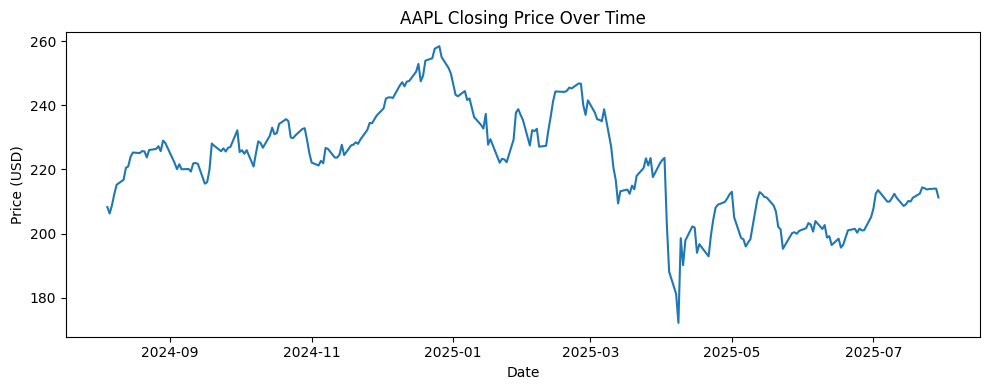

In [12]:
price_df = df[["Date", "Close_AAPL"]].copy()
price_df.set_index("Date", inplace=True)
price_df.head()

plt.figure(figsize=(10, 4))
plt.plot(price_df.index, price_df["Close_AAPL"])
plt.title("AAPL Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


In [13]:
close_values = price_df["Close_AAPL"].values.reshape(-1, 1)

# scaling to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(close_values)

def create_sequences(series, window=60):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled, window=window_size)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (186, 60)
y shape: (186,)


In [14]:
# Use 80% for training, 20% for testing
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM: [samples, timesteps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

X_train_lstm.shape, X_test_lstm.shape


((148, 60, 1), (38, 60, 1))

In [15]:
tf.random.set_seed(42)
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    layers.LSTM(32),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train_lstm, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.3291 - val_loss: 0.0046
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0358 - val_loss: 0.0301
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0345 - val_loss: 0.0048
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0257 - val_loss: 0.0048
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0268 - val_loss: 0.0065
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0180 - val_loss: 0.0143
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0202 - val_loss: 0.0117
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0174 - val_loss: 0.0066
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0169 - val_loss: 0.0058
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0165 - val_loss: 0.0073
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0157 - val_loss: 0.0082
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0155 - val_loss: 0.0067
Epoch 13/20

In [16]:
# model prediction on the test data
pred_scaled = model.predict(X_test_lstm)

# reverse scale back to the price
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
pred_actual    = scaler.inverse_transform(pred_scaled)

rmse_lstm = sqrt(mean_squared_error(y_test_actual, pred_actual))
print("LSTM Test RMSE:", rmse_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
LSTM Test RMSE: 3.7981267073494562


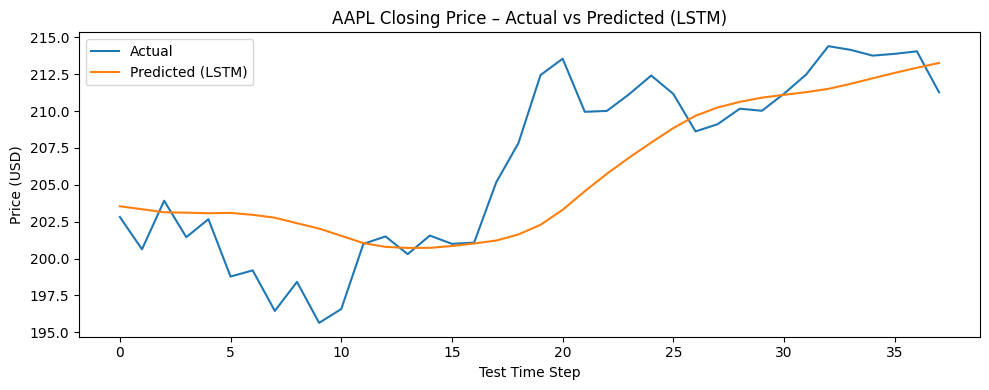

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_actual, label="Actual", linewidth=1.5)
plt.plot(pred_actual, label="Predicted (LSTM)", linewidth=1.5)
plt.title("AAPL Closing Price – Actual vs Predicted (LSTM)")
plt.xlabel("Test Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# For regression baseline, we can use the same X, y (flattened)
X_train_flat = X_train  # shape: (samples, 60)
X_test_flat  = X_test

reg = LinearRegression()
reg.fit(X_train_flat, y_train)

y_pred_reg_scaled = reg.predict(X_test_flat).reshape(-1, 1)

# Inverse scale
y_pred_reg_actual = scaler.inverse_transform(y_pred_reg_scaled)

rmse_reg = sqrt(mean_squared_error(y_test_actual, y_pred_reg_actual))
print("Baseline Linear Regression Test RMSE:", rmse_reg)

Baseline Linear Regression Test RMSE: 7.509167137496519


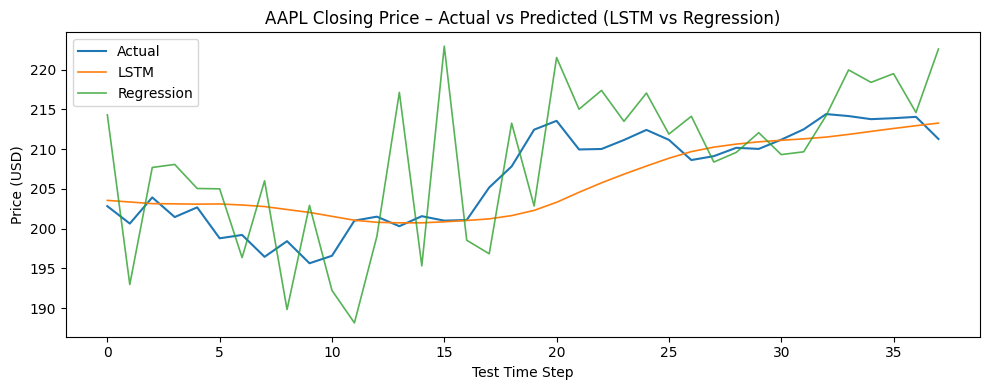

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(y_test_actual, label="Actual", linewidth=1.5)
plt.plot(pred_actual, label="LSTM", linewidth=1.2)
plt.plot(y_pred_reg_actual, label="Regression", linewidth=1.2, alpha=0.8)
plt.title("AAPL Closing Price – Actual vs Predicted (LSTM vs Regression)")
plt.xlabel("Test Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
print("=== Stock Price Prediction Summary ===")
print(f"Total records: {len(price_df)}")
print(f"Window size (days used as input): {window_size}")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"LSTM Test RMSE: {rmse_lstm:.2f}")
print(f"Baseline Regression Test RMSE: {rmse_reg:.2f}")

=== Stock Price Prediction Summary ===
Total records: 246
Window size (days used as input): 60
Train samples: 148, Test samples: 38
LSTM Test RMSE: 3.80
Baseline Regression Test RMSE: 7.51
